# Condition Based Monitoring Gearbox Fault Analysis

## Introduction:

This usage script focuses on extracting a number of damage features for gearbox diagnostics and compares them statistically to determine which would be a good candidate for detecting worn tooth damage of a gearbox vibrations signal. Vibration signals were collected of over a number of instances for a baseline healthy state as well as worn tooth damage state. The bearings on the main shaft used were fluid film bearings which supported the main shaft that drove the gear box. The usage script begins by loading the vibration signals and angular resampling the vibration signal to a specified samples per revolution of the gear shaft. The resampled signal is compared to the raw time signal to demonstrate the improvement of the gear mesh components. The power spectral densities are looked at to see if any visible damage has occurred between the damage state and the baseline state. The residual difference and band pass mesh signals are filtered for the angular resampled signal using fir filtering methods which are used by various gearbox damage features. Then the script plots some time frequency domain figures of merit to see if any useful information can be extracted. Of the four time frequency domains presented the continuous wavelet scalogram is chosen for further processing. The Hoelder exponent is computed from the continuous wavelet scalogram for damage detection in a later damage feature extraction method. Ten damage features are computed from the signals processed earlier on and compared using receiver operating characteristic curves to see which have better performance for the data set.

Requires data_CBM.mat dataset.

**References:**

[1] Randall, Robert., Vibration-based Condition Monitoring, Wiley and Sons, 2011.

[2] Lebold, M.; McClintic, K.; Campbell, R.; Byington, C.; Maynard, K., Review of Vibration Analysis Methods for Gearbox Diagnostics and Prognostics, Proceedings of the 54th Meeting of the Society for Machinery Failure Prevention Technology, Virginia Beach, VA, May 1-4, 2000, p. 623-634.

**SHMTools functions called:**

ars_tach_shm, crest_factor_shm, cwt_scalogram_shm, demean_shm, dwvd_shm, filter_shm, fir1_shm, fm0_shm, fm4_shm, hoelder_exp_shm, import_cbm_data_shm, lpc_spectrogram_shm, m6a_shm, m8a_shm, na4m_shm, nb4m_shm, rms_shm, plot_psd_shm, plot_roc_shm, plot_time_freq_shm, plot_scalogram_shm, psd_welch_shm, roc_shm, stat_moments_shm, stft_shm, window_shm

**Author:** Luke Robinson

**Date Created:** July 25, 2013

**LA-CC-14-046**  
Copyright (c) 2014, Los Alamos National Security, LLC  
All rights reserved.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Import shmtools (installed package)
from examples.data import import_cbm_data_shm
from shmtools.core.preprocessing import demean_shm, filter_shm, window_shm
from shmtools.core.cbm_processing import ars_tach_shm
from shmtools.core.signal_processing import fir1_shm
from shmtools.core.spectral import (
    psd_welch_shm, dwvd_shm, lpc_spectrogram_shm, stft_shm, cwt_scalogram_shm, hoelder_exp_shm
)
from shmtools.core.statistics import (
    crest_factor_shm, stat_moments_shm, rms_shm, fm0_shm, fm4_shm, m6a_shm, m8a_shm, na4m_shm, nb4m_shm
)
from shmtools.classification.outlier_detection import roc_shm
from shmtools.plotting.spectral_plots import (
    plot_psd_shm, plot_time_freq_shm, plot_scalogram_shm, plot_features_shm
)

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## Begin Gear Box Damage Analysis Script

In [2]:
# Load Desired Data States and Channels for Outter Race Bearing Damage w/
# Channel 2: Accel Mounted on Gearbox
dataset, damage_states, state_list, fs = import_cbm_data_shm()

# Convert to boolean mask - ensure correct dimensions
states = (state_list.flatten() == 1) | (state_list.flatten() == 3)
channels = [0, 1]  # tachyometer and accel (Python 0-based indexing)

# Extract data using proper indexing
X = dataset[:, channels, :]  # First get the channels
X = X[:, :, states]  # Then filter by states
damageStates = damage_states[states]
stateList = state_list.flatten()[states]

iBaseline = np.where(stateList == 1)[0]
iDamage = np.where(stateList == 3)[0]
X = demean_shm(X)

print(f"Data loaded - Shape: {X.shape}")
print(f"Sampling frequency: {fs} Hz")
print(f"Baseline instances: {len(iBaseline)}")
print(f"Damage instances: {len(iDamage)}")
print(f"States shape: {states.shape}, sum: {np.sum(states)}")
print(f"Original stateList shape: {stateList.shape}")

Data loaded - Shape: (10240, 2, 128)
Sampling frequency: 2048.0 Hz
Baseline instances: 64
Damage instances: 64
States shape: (384,), sum: 128
Original stateList shape: (128,)


## 1) Look at an Example Time and Frequency Series

Initial time and frequency domain plots complete


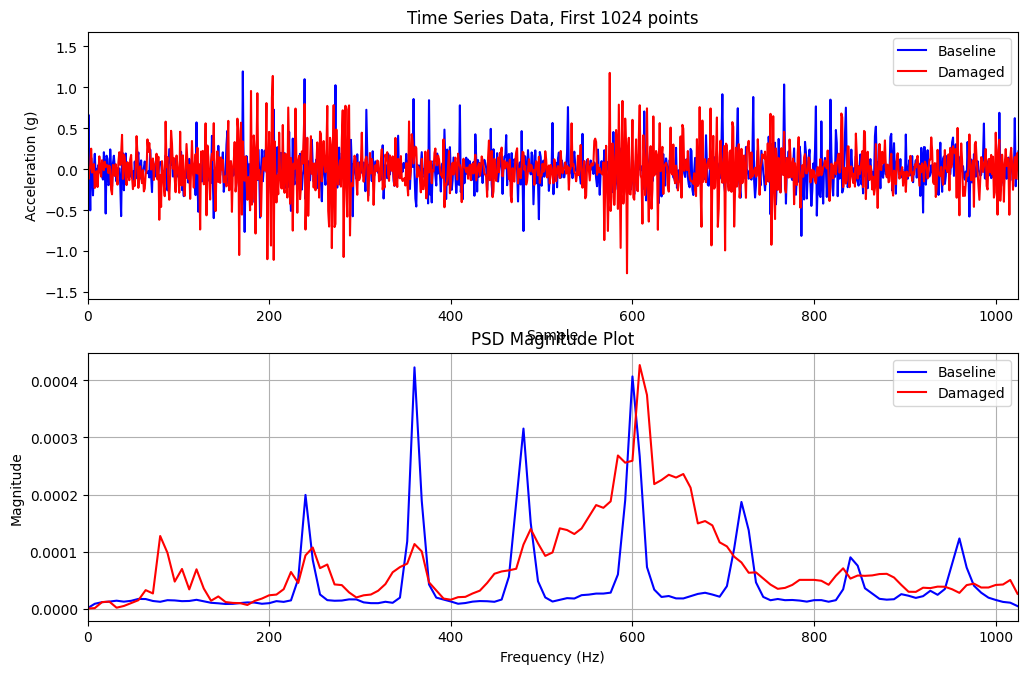

In [3]:
# Plot instance Number
instance = 2  # Python 0-based (MATLAB used 3)

fig = plt.figure(figsize=(12, 16))

# Time Series Comparison
plt.subplot(4, 1, 1)
plt.plot(X[:, 1, iBaseline[instance]], 'b', label='Baseline')
plt.plot(X[:, 1, iDamage[instance]], 'r', label='Damaged')
plt.xlim([0, 1024])
plt.title('Time Series Data, First 1024 points')
plt.xlabel('Sample')
plt.ylabel('Acceleration (g)')
plt.legend()

# Frequency Domain Comparison
plt.subplot(4, 1, 2)
test_data = X[:, 1:2, [iBaseline[instance], iDamage[instance]]]
psdMatrix, f, is1sided = psd_welch_shm(test_data, None, None, None, fs, None)
plt.plot(f, psdMatrix[:, 0, 0], 'b', label='Baseline')
plt.plot(f, psdMatrix[:, 0, 1], 'r', label='Damaged')
plt.grid(True)
plt.title('PSD Magnitude Plot')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend()
plt.xlim([0, fs/2])  # Limit to Nyquist frequency for clarity

print("Initial time and frequency domain plots complete")

## 2) Order Track using ARSTach and ARSAccel for further refinement.

The data in this example was retrieved from a system that had minor speed fluctuations in the main shaft speed. The shaft speed variation was on the order or +/- 3RPM. signalARSTach uses a single pulse per rotation signal to resample a time domain signal that may have large speed fluctuations into a vibration signal tracked to orders of the shaft rotation in an equally space angular domain. This improves periodic frequency components that would have smeared from shaft speed fluctuations. The tachometer is located on the main shaft but the gear box is separated by a belt drive with a gear ratio equal to 1:3.71 and must be accounted for to resample to the gearbox shaft. nFilter is used for various anti-aliasing functionality in signalARSTach. signalARSTach by default uses a Kaiser windowed fir filter with a beta shape function set to 4 as its filter type.

In [4]:
# arsTach_shm Input:
nFilter = 255        # Anti-Alias Filter Length
samplesPerRev = 512  # Desired Samples per Rev
gearRatio = 1/3.71   # Main Shaft:Gear Shaft Ratio

xARSMatrixT, samplesPerRev = ars_tach_shm(X, nFilter, samplesPerRev, gearRatio)

print(f"Angular resampling complete - Samples per revolution: {samplesPerRev}")
print(f"Resampled data shape: {xARSMatrixT.shape}")

Angular resampling complete - Samples per revolution: 512
Resampled data shape: (9728, 1, 128)


## Compare Resampled Angular Series and Frequency Domain Content

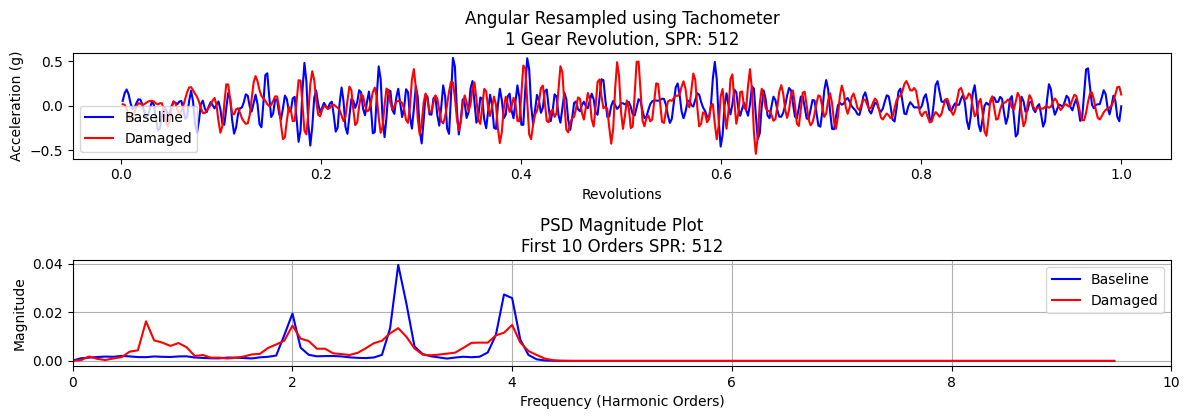

Angular resampling comparison complete


In [5]:
# Angular Series Comparison
plt.subplot(4, 1, 3)
rev_range = np.arange(1, samplesPerRev + 1) / samplesPerRev
plt.plot(rev_range, xARSMatrixT[:samplesPerRev, 0, iBaseline[instance]], 'b', label='Baseline')
plt.plot(rev_range, xARSMatrixT[:samplesPerRev, 0, iDamage[instance]], 'r', label='Damaged')
plt.title(f'Angular Resampled using Tachometer\n1 Gear Revolution, SPR: {samplesPerRev}')
plt.xlabel('Revolutions')
plt.ylabel('Acceleration (g)')
plt.legend()

# Frequency Domain Comparison - corrected sampling frequency
plt.subplot(4, 1, 4)
test_ars_data = xARSMatrixT[:, 0:1, [iBaseline[instance], iDamage[instance]]]
psdMatrix, f, is1sided = psd_welch_shm(test_ars_data, None, None, None, samplesPerRev/27, None)
plt.plot(f, psdMatrix[:, 0, 0], 'b', label='Baseline')
plt.plot(f, psdMatrix[:, 0, 1], 'r', label='Damaged')
plt.grid(True)
plt.title(f'PSD Magnitude Plot\nFirst 10 Orders SPR: {samplesPerRev}')
plt.xlabel('Frequency (Harmonic Orders)')
plt.ylabel('Magnitude')
plt.legend()
# Set reasonable x-axis limit to show first several orders clearly
plt.xlim([0, 10])

plt.tight_layout()
plt.show()

print("Angular resampling comparison complete")

## 3) Look at Average Power Spectral Density for the Baseline Case

Comparing the power spectral densities it can be seen that the periodic gear mesh harmonics begin to smear and frequency energy not associated with the gear meshing increases as the gear teeth begin to wear.

Power spectral density analysis complete


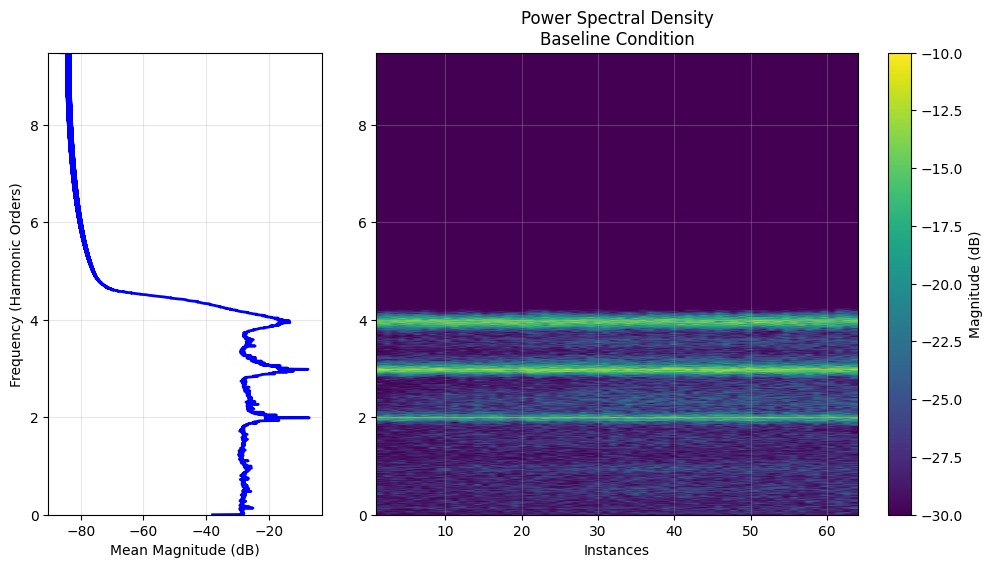

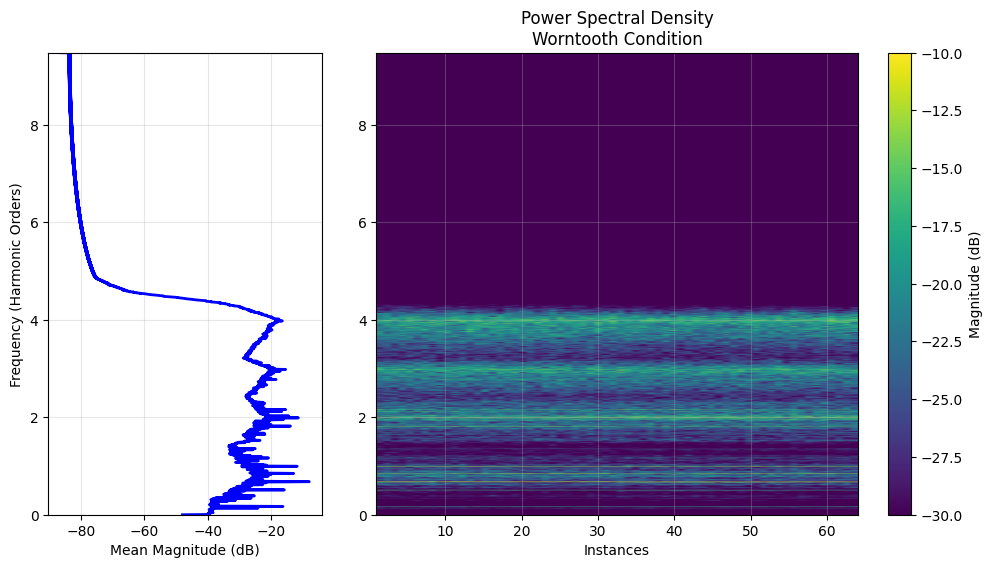

In [6]:
# psdWelch_shm Input:
nWin = 2**(int(np.log2(xARSMatrixT.shape[0])) - 1)
nOvlap = int(nWin * 0.75)
nFFT = nWin * 2
Fs_psd = samplesPerRev / 27

psdMatrix, f, is1sided = psd_welch_shm(xARSMatrixT, nWin, nOvlap, nFFT, Fs_psd, None)

# Plot baseline condition - matches MATLAB plotPSD_shm behavior
ax_baseline = plot_psd_shm(psdMatrix[:, :, iBaseline], 1, is1sided, f, True, True, None)
# Set color limits to match MATLAB: caxis([-30, -10])
ax_baseline[0].images[0].set_clim([-30, -10])
ax_baseline[0].set_title('Power Spectral Density\nBaseline Condition')
if len(ax_baseline) > 1 and ax_baseline[1] is not None:
    ax_baseline[1].set_ylabel('Frequency (Harmonic Orders)')

# Plot damage condition
ax_damage = plot_psd_shm(psdMatrix[:, :, iDamage], 1, is1sided, f, True, True, None)
# Set color limits to match MATLAB: caxis([-30, -10])
ax_damage[0].images[0].set_clim([-30, -10])
ax_damage[0].set_title('Power Spectral Density\nWorntooth Condition')
if len(ax_damage) > 1 and ax_damage[1] is not None:
    ax_damage[1].set_ylabel('Frequency (Harmonic Orders)')

print("Power spectral density analysis complete")

## 4) Filter xARS to get Residual, Difference and Band Pass Signal.

Filtering of the angular resampled signal is used to determine three traditional processed signals used in gearbox damage detection. Here the signals are filtered and plotted for comparison. The residual signal consists of the angular resampled signal with the shaft and gear mesh frequencies filtered out. To do this a narrow band fir filter is used and set to filter ate gear mesh orders with a width of an estimate of the first order sideband. The difference signal is similar to the residual signal but its band width is set to be a little larger than that of the residual signal filter to also filter out first order sidebands. The band pass gear mesh signal is the angular resampled signal with all frequency components filtered out except gear mesh harmonics and the first order sidebands.

In [7]:
# Filter Out Drive Shaft
nGearTeeth = 27
Fs_filter = samplesPerRev        # Cycles/Rev
fDrive = 1                       # Cycles/Rev
fHarmonic = nGearTeeth          # Cycles/Rev
fSideBand = 1                   # Cycles/Rev

# Constant Filtering Parameters  
nFilter = 511  # Odd number of filter coefficients
nDelay = int(np.ceil((nFilter - 1) / 2))

# Filter Out Drive Shaft Frequency
Wn = fDrive / Fs_filter
filterType = 'high'

# Use scipy directly to avoid window compatibility issues
from scipy import signal
filterCoef = signal.firwin(nFilter, Wn, pass_zero='highpass', window=('kaiser', 4))
y = filter_shm(xARSMatrixT, filterCoef)

print(f"Drive shaft filtering complete - Filter length: {nFilter}")
print(f"Filtered signal shape: {y.shape}")

Drive shaft filtering complete - Filter length: 511
Filtered signal shape: (9728, 1, 128)


In [8]:
# Residual Signal Filtering out Gear Mesh (Initialize Filter)
index = 1
Fc = index * fHarmonic
xResidual = y.copy()
filterType = 'bandstop'
filterContinue = True

while filterContinue:
    Wn = np.array([Fc - fSideBand, Fc + fSideBand]) / Fs_filter
    # Ensure valid frequency range
    Wn = np.clip(Wn, 0.001, 0.999)
    
    # Use scipy directly
    from scipy import signal
    filterCoef = signal.firwin(nFilter, Wn, pass_zero='bandstop', window=('kaiser', 4))
    xResidual = filter_shm(xResidual, filterCoef)
    
    index += 1
    Fc = fHarmonic * index
    
    if (Fc + fSideBand) >= Fs_filter / 2:
        filterContinue = False

# Remove Filter Delay
xResidual = xResidual[nDelay:, :, :]

print(f"Residual signal filtering complete - {index-1} harmonics filtered")
print(f"Residual signal shape: {xResidual.shape}")

Residual signal filtering complete - 9 harmonics filtered
Residual signal shape: (9473, 1, 128)


In [9]:
# Difference Signal Filtering out Gear Mesh (Initialize Filter)
index = 1
Fc = index * fHarmonic
xDifference = y.copy()
filterType = 'bandstop'
filterContinue = True

while filterContinue:
    Wn = np.array([Fc - 2*fSideBand, Fc + 2*fSideBand]) / Fs_filter
    # Ensure valid frequency range
    Wn = np.clip(Wn, 0.001, 0.999)
    
    # Use scipy directly
    from scipy import signal
    filterCoef = signal.firwin(nFilter, Wn, pass_zero='bandstop', window=('kaiser', 4))
    xDifference = filter_shm(xDifference, filterCoef)
    
    index += 1
    Fc = fHarmonic * index
    
    if (Fc + 2*fSideBand) >= Fs_filter / 2:
        filterContinue = False

# Remove Filter Delay
xDifference = xDifference[nDelay:, :, :]

print(f"Difference signal filtering complete - {index-1} harmonics filtered")
print(f"Difference signal shape: {xDifference.shape}")

Difference signal filtering complete - 9 harmonics filtered
Difference signal shape: (9473, 1, 128)


In [10]:
# Band Pass Mesh Signal Filtering out All but Gear Mesh (Initialize Filter)
index = 0
Fc = fHarmonic / 2
xBandPassMesh = y.copy()
filterType = 'bandstop'
filterContinue = True

while filterContinue:
    if index == 0:
        Wn = np.array([0.00001, Fc + (fHarmonic/2 - fSideBand)]) / Fs_filter
    else:
        Wn = np.array([Fc - (fHarmonic/2 - fSideBand), Fc + (fHarmonic/2 - fSideBand)]) / Fs_filter
    
    # Ensure valid frequency range
    Wn = np.clip(Wn, 0.001, 0.999)
    
    # Use scipy directly
    from scipy import signal
    filterCoef = signal.firwin(nFilter, Wn, pass_zero='bandstop', window=('kaiser', 4))
    xBandPassMesh = filter_shm(xBandPassMesh, filterCoef)
    
    index += 1
    Fc = fHarmonic * (index + 0.5)
    
    if ((Fc + (fHarmonic/2 - fSideBand)) / Fs_filter) >= 0.5:
        Wn = np.array([Fc - (fHarmonic/2 - fSideBand), Fs_filter/2 - 0.0001]) / Fs_filter
        Wn = np.clip(Wn, 0.001, 0.999)
        filterCoef = signal.firwin(nFilter, Wn, pass_zero='bandstop', window=('kaiser', 4))
        xBandPassMesh = filter_shm(xBandPassMesh, filterCoef)
        filterContinue = False

# Remove Filter Delay
xBandPassMesh = xBandPassMesh[nDelay:, :, :]

print(f"Band-pass mesh signal filtering complete")
print(f"Band-pass mesh signal shape: {xBandPassMesh.shape}")

Band-pass mesh signal filtering complete
Band-pass mesh signal shape: (9473, 1, 128)


## Look at Average Power Spectral Density for New Signals

Of the four time frequency plots shown, the continuous wavelet scalogram presents the best option for detection nonlinearities in a signal. The gear mesh impulses can be detected in the high frequency bin. By design continuous wavelet scalograms have good frequency resolution and poor time resolution for low frequencies and good time resolution but poor frequency resolution at high frequencies. Impulses create broad band noise and this can be seen in the high frequency range of the scalogram which directly corresponds to gear teeth impacts that are extracted using the Hoelder exponent. The other time frequency plots, in order to get good time resolution the must use small window sizes which cause a lot of smearing in the frequency content.

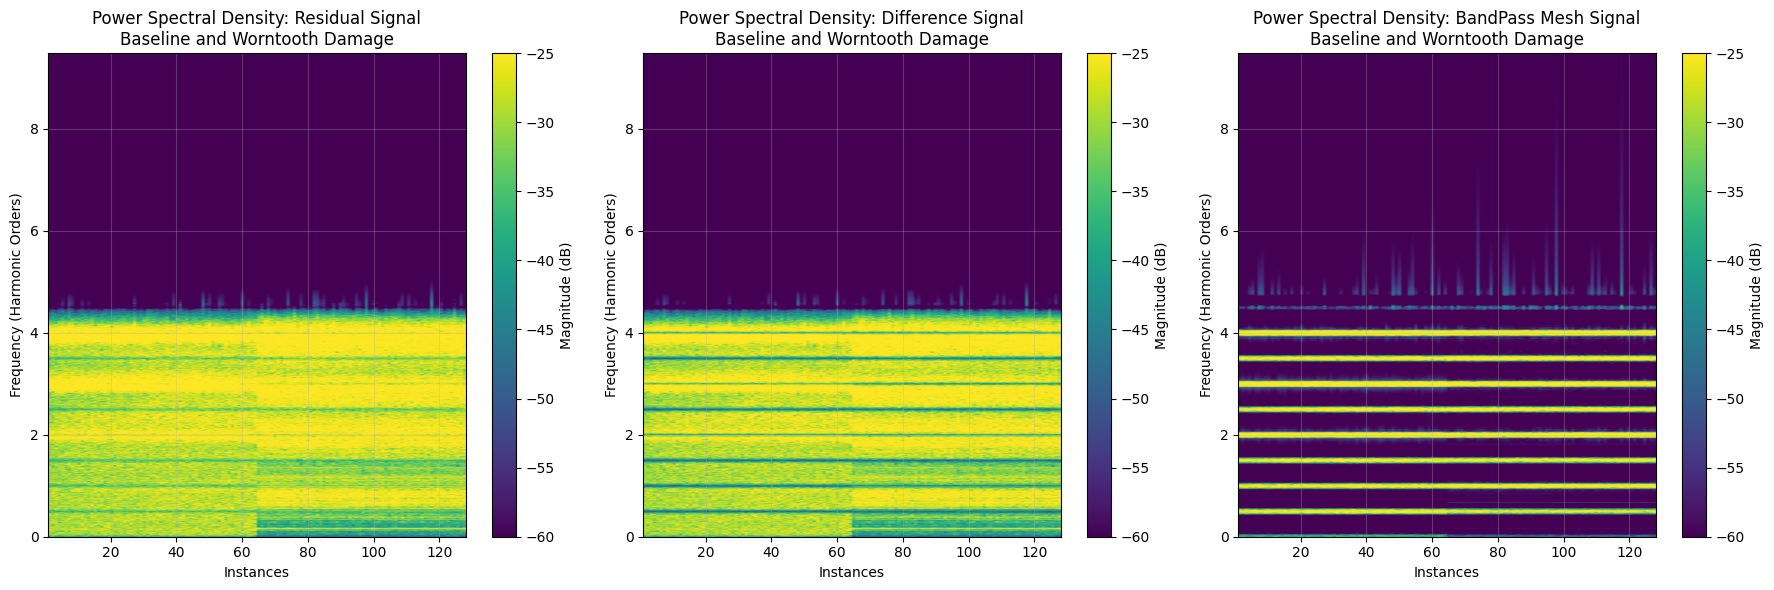

Filtered signal PSD analysis complete


In [11]:
# psdWelch_shm Input:
nWin = 2**(int(np.log2(xResidual.shape[0])) - 1)
nOvlap = int(nWin * 0.75)
nFFT = nWin * 2
Fs_filtered = samplesPerRev / nGearTeeth

# Create figure to match MATLAB subplot(1,3,x) layout
fig = plt.figure(figsize=(18, 6))

# Plot PSD of all instances of the residual signal
psdMatrix, f, is1sided = psd_welch_shm(xResidual, nWin, nOvlap, nFFT, Fs_filtered, None)
ax1 = plt.subplot(1, 3, 1)
plot_psd_shm(psdMatrix, 1, is1sided, f, True, False, ax1)
ax1.images[0].set_clim([-60, -25])  # Match MATLAB caxis([-60, -25])
ax1.set_title('Power Spectral Density: Residual Signal\nBaseline and Worntooth Damage')
ax1.set_ylabel('Frequency (Harmonic Orders)')

# Plot PSD of all instances of the difference signal
psdMatrix, f, is1sided = psd_welch_shm(xDifference, nWin, nOvlap, nFFT, Fs_filtered, None)
ax2 = plt.subplot(1, 3, 2)
plot_psd_shm(psdMatrix, 1, is1sided, f, True, False, ax2)
ax2.images[0].set_clim([-60, -25])  # Match MATLAB caxis([-60, -25])
ax2.set_title('Power Spectral Density: Difference Signal\nBaseline and Worntooth Damage')
ax2.set_ylabel('Frequency (Harmonic Orders)')

# Plot PSD of all instances of the band pass mesh signal
psdMatrix, f, is1sided = psd_welch_shm(xBandPassMesh, nWin, nOvlap, nFFT, Fs_filtered, None)
ax3 = plt.subplot(1, 3, 3)
plot_psd_shm(psdMatrix, 1, is1sided, f, True, False, ax3)
ax3.images[0].set_clim([-60, -25])  # Match MATLAB caxis([-60, -25])
ax3.set_title('Power Spectral Density: BandPass Mesh Signal\nBaseline and Worntooth Damage')
ax3.set_ylabel('Frequency (Harmonic Orders)')

plt.tight_layout()
plt.show()

print("Filtered signal PSD analysis complete")

## 5) Look at Time Frequency Domain


Processing Baseline condition:


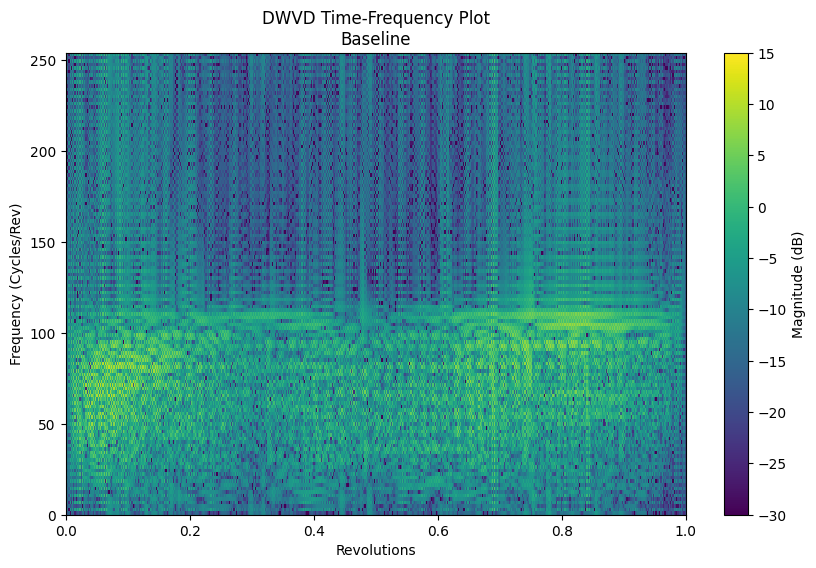

LPC Spectrogram failed: Input X must be 3-dimensional (TIME, CHANNELS, INSTANCES), got 1D


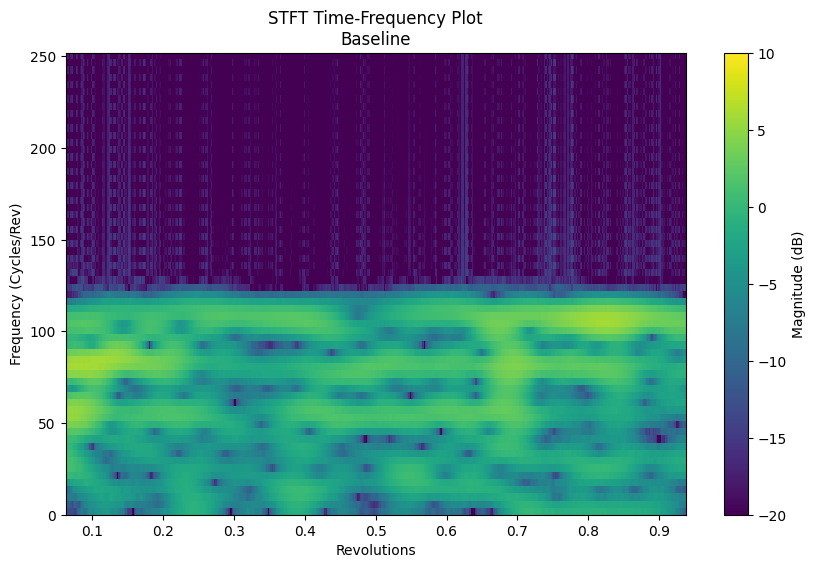

/Users/eric/repo/shm/shmtools/core/spectral.py:828: ComplexWarning: Casting complex values to real discards the imaginary part
  scalo[i, :] = CWT[start_idx:end_idx]


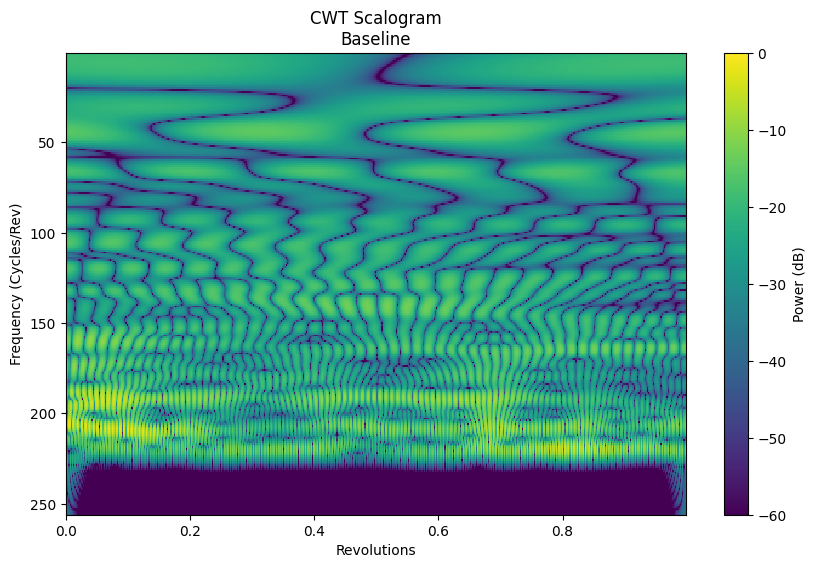


Processing Damaged condition:


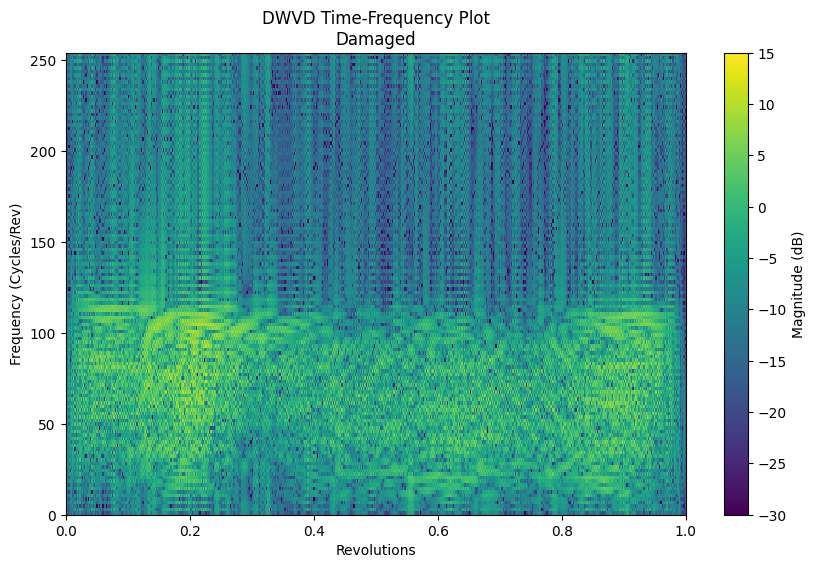

LPC Spectrogram failed: Input X must be 3-dimensional (TIME, CHANNELS, INSTANCES), got 1D


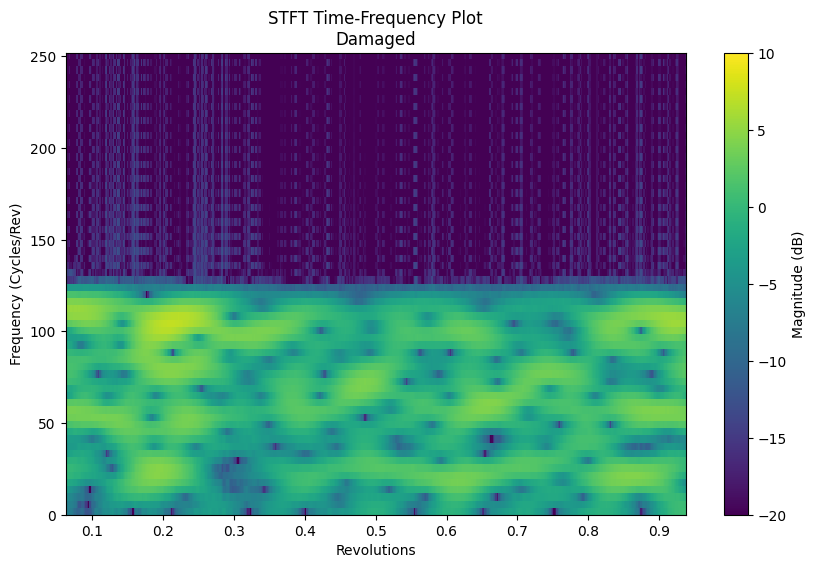

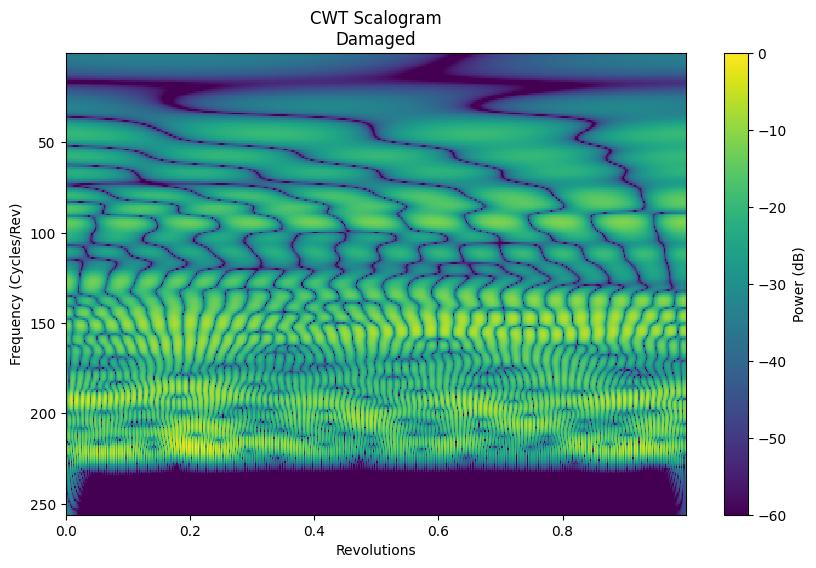


Time-frequency domain analysis complete


In [12]:
for i in range(2):
    index = 3  # Python 0-based (MATLAB used 4)
    instance = [iBaseline[index], iDamage[index]]
    stateTitle = ['Baseline', 'Damaged']
    
    print(f"\nProcessing {stateTitle[i]} condition:")
    
    # dwvd_shm Input:
    nWin = 65
    nOvlap = nWin - 1
    nFFT = nWin * 2
    Fs_tf = samplesPerRev
    
    signal_segment = xARSMatrixT[:samplesPerRev, :, instance[i]]
    # Fix: reshape to add instance dimension for spectral functions
    signal_segment = signal_segment.reshape(signal_segment.shape[0], signal_segment.shape[1], 1)
    
    dwvdMatrix, f, t = dwvd_shm(signal_segment, nWin, nOvlap, nFFT, Fs_tf)
    
    # Plot Discrete Wigner-Ville
    fig, ax = plt.subplots(figsize=(10, 6))
    plot_time_freq_shm(dwvdMatrix[:, :, 0, 0], None, None, t, f, None, ax)
    ax.images[0].set_clim([-30, 15])  # Match MATLAB caxis([-30, 15])
    ax.set_title(f'DWVD Time-Frequency Plot\n{stateTitle[i]}')
    ax.set_ylabel('Frequency (Cycles/Rev)')
    ax.set_xlabel('Revolutions')
    plt.show()
    
    # lpcSpectrogram_shm Input:
    modelOrder = 42
    nWin = 64
    nOvlap = nWin - 1
    nFFT = nWin * 2
    Fs_tf = samplesPerRev
    
    try:
        lpcSpecMatrix, f, t = lpc_spectrogram_shm(signal_segment, modelOrder, nWin, nOvlap, nFFT, Fs_tf)
        
        # Plot LPC Spectrogram
        fig, ax = plt.subplots(figsize=(10, 6))
        plot_time_freq_shm(lpcSpecMatrix[:, :, 0, 0], None, None, t, f, None, ax)
        ax.images[0].set_clim([-5, 15])  # Match MATLAB caxis([-5, 15])
        ax.set_title(f'LPC Spectrogram Time-Frequency Plot\n{stateTitle[i]}')
        ax.set_ylabel('Frequency (Cycles/Rev)')
        ax.set_xlabel('Revolutions')
        plt.show()
    except Exception as e:
        print(f"LPC Spectrogram failed: {e}")
    
    # stft_shm Input:
    nWin = 64
    nOvlap = nWin - 1
    nFFT = nWin * 2
    Fs_tf = samplesPerRev
    
    stftMatrix, f, t = stft_shm(signal_segment, nWin, nOvlap, nFFT, Fs_tf)
    
    # Plot STFT
    fig, ax = plt.subplots(figsize=(10, 6))
    plot_time_freq_shm(stftMatrix[:, :, 0, 0], None, None, t, f, None, ax)
    ax.images[0].set_clim([-20, 10])  # Match MATLAB caxis([-20, 10])
    ax.set_title(f'STFT Time-Frequency Plot\n{stateTitle[i]}')
    ax.set_ylabel('Frequency (Cycles/Rev)')
    ax.set_xlabel('Revolutions')
    plt.show()
    
    # cwtScalogram_shm Input:
    Fs_cwt = samplesPerRev
    fMin = None
    fMax = None
    nScale = 256
    waveOrder = None
    waveType = None
    useAnalytic = True
    
    scaloMatrix, f, timeVector = cwt_scalogram_shm(signal_segment, Fs_cwt, fMin, fMax, nScale, waveOrder, waveType, useAnalytic)
    
    # Plot CWT
    fig, ax = plt.subplots(figsize=(10, 6))
    plot_scalogram_shm(scaloMatrix[:, :, 0, 0], None, None, timeVector, f, ax)
    ax.images[0].set_clim([-60, 0])  # Match MATLAB caxis([-60, 0])
    ax.set_title(f'CWT Scalogram\n{stateTitle[i]}')
    ax.set_ylabel('Frequency (Cycles/Rev)')
    ax.set_xlabel('Revolutions')
    plt.show()

print("\nTime-frequency domain analysis complete")

## 6) Get Hoelder Series from CWTScalo

The Hoelder exponent is a measure of the slope of the energy content in a time frequency domain. As high frequency energy rises and falls so too does the value of the Hoelder exponent. As previously stated this picks up on impacts or nonlinearities in a signal that cause increases in high energy content. By looking at the frequency domain of the Hoelder exponent for a gear it is possible to track the impulses of gear teeth and as the wear the magnitude of these impulses in the Hoelder domain will begin to decay making it useful in monitoring gear teeth wear.

In [13]:
# cwtScalogram_shm Input:
Fs_hoelder = samplesPerRev
fMin = None
fMax = None
nScale = 64
waveOrder = None
waveType = None
useAnalytic = True

scaloMatrix, f, t = cwt_scalogram_shm(xARSMatrixT, Fs_hoelder, fMin, fMax, nScale, waveOrder, waveType, useAnalytic)
hoelderMatrix = hoelder_exp_shm(scaloMatrix, f)
hoelderMatrix = demean_shm(hoelderMatrix)

print(f"Hoelder exponent computation complete")
print(f"Hoelder matrix shape: {hoelderMatrix.shape}")

Hoelder exponent computation complete
Hoelder matrix shape: (9728, 1, 128)


## Plot Hoelder Series in Time and Frequency Domain

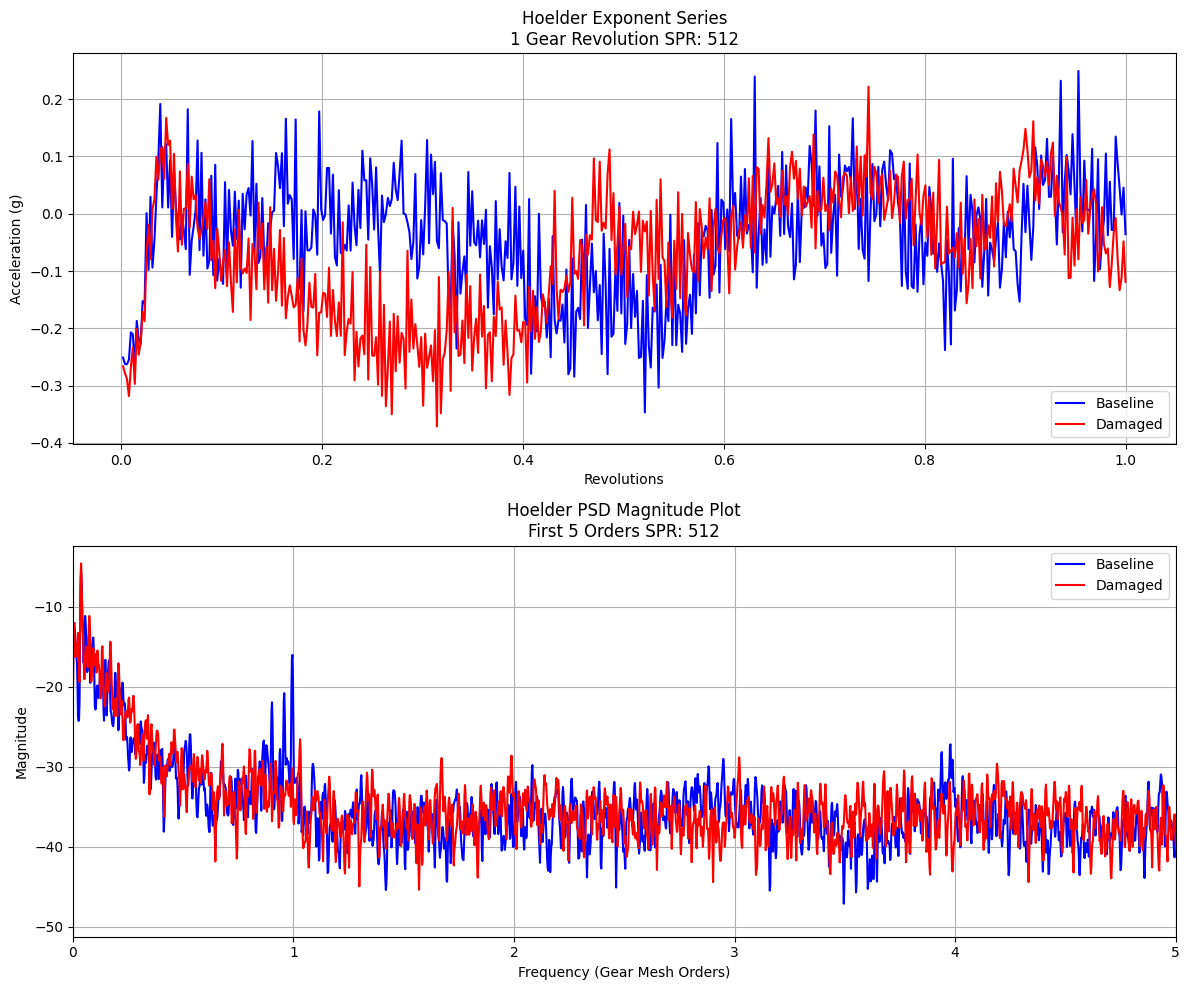

Hoelder exponent time and frequency domain analysis complete


In [14]:
# psdWelch Input:
nWin = 2**(int(np.log2(xResidual.shape[0])) - 1)
nOvlap = int(nWin * 0.75)
nFFT = nWin * 2
Fs_hoelder_psd = samplesPerRev / nGearTeeth

psdMatrix, f = psd_welch_shm(hoelderMatrix, nWin, nOvlap, nFFT, Fs_hoelder_psd, None)[:2]
psdMatrix = 10 * np.log10(psdMatrix + 1e-12)

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

instance = 5  # Python 0-based (MATLAB used 6)

# Angular Series Comparison
rev_range = np.arange(1, samplesPerRev + 1) / samplesPerRev
axes[0].plot(rev_range, hoelderMatrix[:samplesPerRev, 0, iBaseline[instance]], 'b', label='Baseline')
axes[0].plot(rev_range, hoelderMatrix[:samplesPerRev, 0, iDamage[instance]], 'r', label='Damaged')
axes[0].grid(True)
axes[0].set_title(f'Hoelder Exponent Series\n1 Gear Revolution SPR: {samplesPerRev}')
axes[0].set_xlabel('Revolutions')
axes[0].set_ylabel('Acceleration (g)')
axes[0].legend()

# Frequency Domain Comparison
axes[1].plot(f, psdMatrix[:, 0, iBaseline[instance]], 'b', label='Baseline')
axes[1].plot(f, psdMatrix[:, 0, iDamage[instance]], 'r', label='Damaged')
axes[1].grid(True)
axes[1].set_xlim([0, 5])
axes[1].set_title(f'Hoelder PSD Magnitude Plot\nFirst 5 Orders SPR: {samplesPerRev}')
axes[1].set_xlabel('Frequency (Gear Mesh Orders)')
axes[1].set_ylabel('Magnitude')
axes[1].legend()

plt.tight_layout()
plt.show()

print("Hoelder exponent time and frequency domain analysis complete")

## 7) Look at Some Common Feature Types

Several features are compared here. Raw signal features like crest factor kurtosis and root mean square are good at detection damage but the damage features suffer from a lack of localization in determining the cause of change. Increases in load and speed can cause a large change in the value of these features. FM0 uses the resampled signal and track the gear mesh orders which makes it tuned to the gear in question. FMH is similar to FM0 but uses the Hoelder series instead giving it improved separation in the damage features between baseline and worn tooth states. The residual and difference signals monitor changes in the frequency content other than that of gear mesh harmonics and sidebands and the band pass mesh signal features monitor the kurtosis of the enveloped signal of primarily gear mesh harmonics.

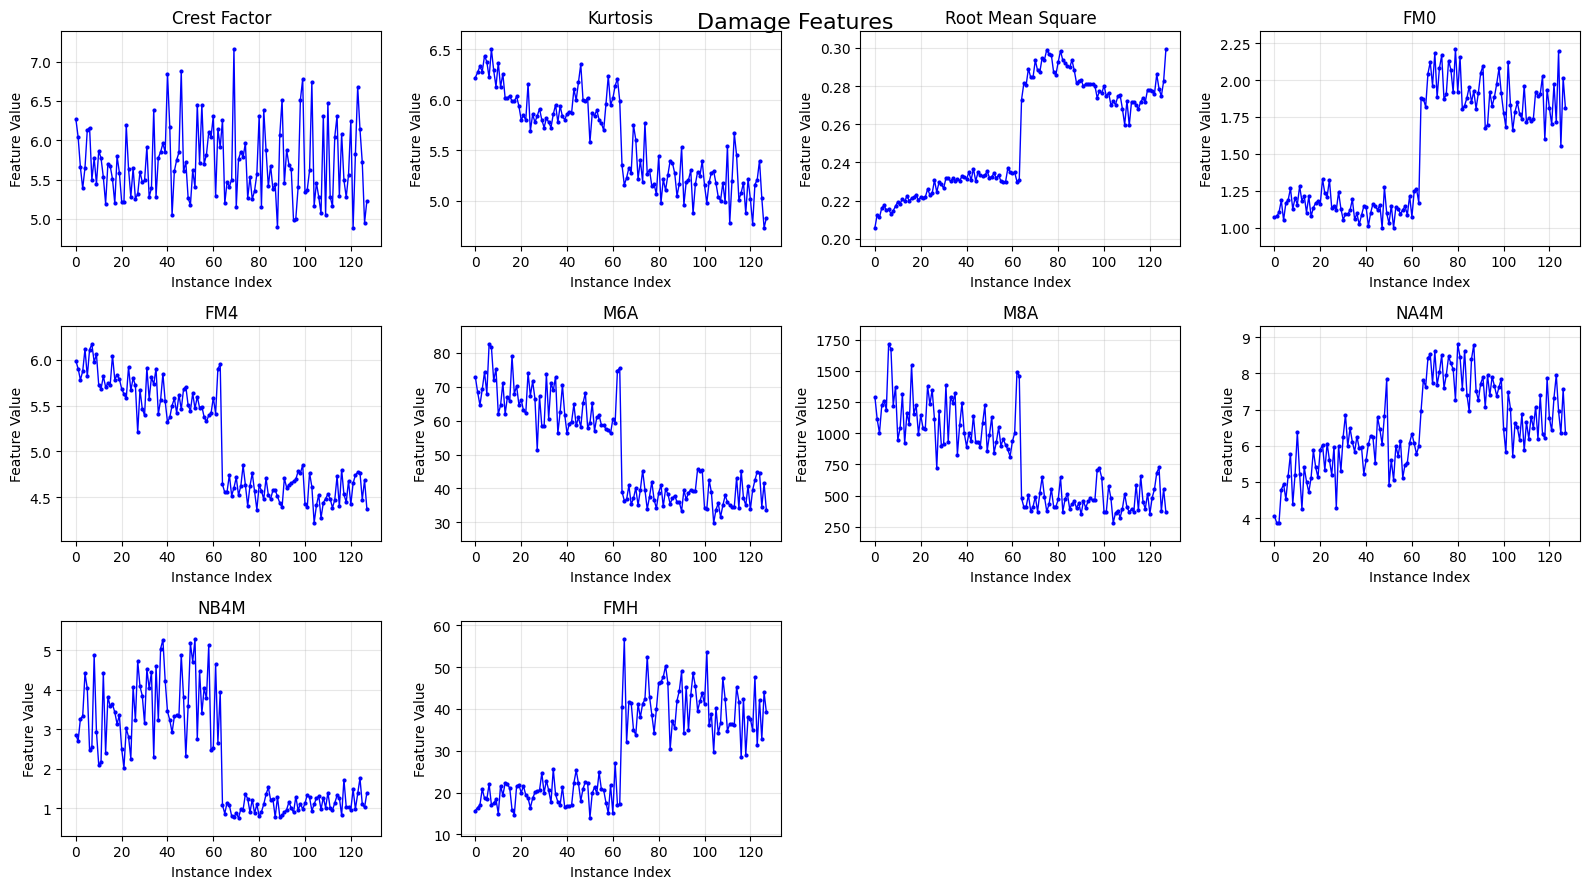

Feature extraction complete - 10 features extracted
Features shape: (128, 10)
Expected: (128, 10)
Baseline instances: 64, Damage instances: 64


In [15]:
# Raw Signal Damage Features - use channel 1 (accelerometer, 0-based indexing)
cf = crest_factor_shm(X[:, 1:2, :])  # Use accelerometer channel
statisticsFV = stat_moments_shm(X[:, 1:2, :])  # Use accelerometer channel
kurt = statisticsFV[:, 3]  # Kurtosis (4th moment, 0-based indexing)
rms = rms_shm(X[:, 1:2, :])  # Use accelerometer channel

# Resampled Signal Damage Features
fundMeshFreq = fHarmonic / samplesPerRev
trackOrders = [1, 2, 3]
nFFT = None
nBinSearch = 3
fm0 = fm0_shm(xARSMatrixT, fundMeshFreq, trackOrders, nFFT, nBinSearch)

# Residual Signal Damage Features
fm4 = fm4_shm(xResidual)
m6a = m6a_shm(xResidual)
m8a = m8a_shm(xResidual)

# Difference Signal Damage Features
na4mBase, m2 = na4m_shm(xDifference[:, :, iBaseline], None)
na4mDamage, temp = na4m_shm(xDifference[:, :, iDamage], m2)
na4m = np.concatenate([na4mBase, na4mDamage])

# Bandpass Mesh Signal
nb4mBase, m2 = nb4m_shm(xBandPassMesh[:, :, iBaseline], None)
nb4mDamage, temp = nb4m_shm(xBandPassMesh[:, :, iDamage], m2)
nb4m = np.concatenate([nb4mBase, nb4mDamage])

# Hoelder Signal Damage Features
fundMeshFreq = fHarmonic / samplesPerRev
trackOrders = [1, 2, 3]
nFFT = None
nBinSearch = 3
fmH = fm0_shm(hoelderMatrix, fundMeshFreq, trackOrders, nFFT, nBinSearch)

# Plot Damage Features - ensure feature arrays have the right shape
features = np.column_stack([cf.flatten(), kurt.flatten(), rms.flatten(), fm0.flatten(), fm4.flatten(),
                           m6a.flatten(), m8a.flatten(), na4m.flatten(), nb4m.flatten(), fmH.flatten()])
featNames = ['Crest Factor', 'Kurtosis', 'Root Mean Square', 'FM0', 'FM4',
             'M6A', 'M8A', 'NA4M', 'NB4M', 'FMH']

plot_features_shm(features, None, None, featNames, None, None)
plt.suptitle('Damage Features', fontsize=16)
plt.show()

print(f"Feature extraction complete - {len(featNames)} features extracted")
print(f"Features shape: {features.shape}")
print(f"Expected: ({len(iBaseline) + len(iDamage)}, {len(featNames)})")
print(f"Baseline instances: {len(iBaseline)}, Damage instances: {len(iDamage)}")

## 8) Compare Damage Features Statistically - Plot ROC Curves

To compare the damage features detectability statistically, receiver operating characteristic curves can be used to show the probability of detection vs. the probability of false alarm. Damage features with a high probability of detection to false alarm rate are optimal detectors. From the ROC curves the four best performing damage features for the data provided were NA4M, root mean square, FM0 and FMH which all had perfect detection in this data set.

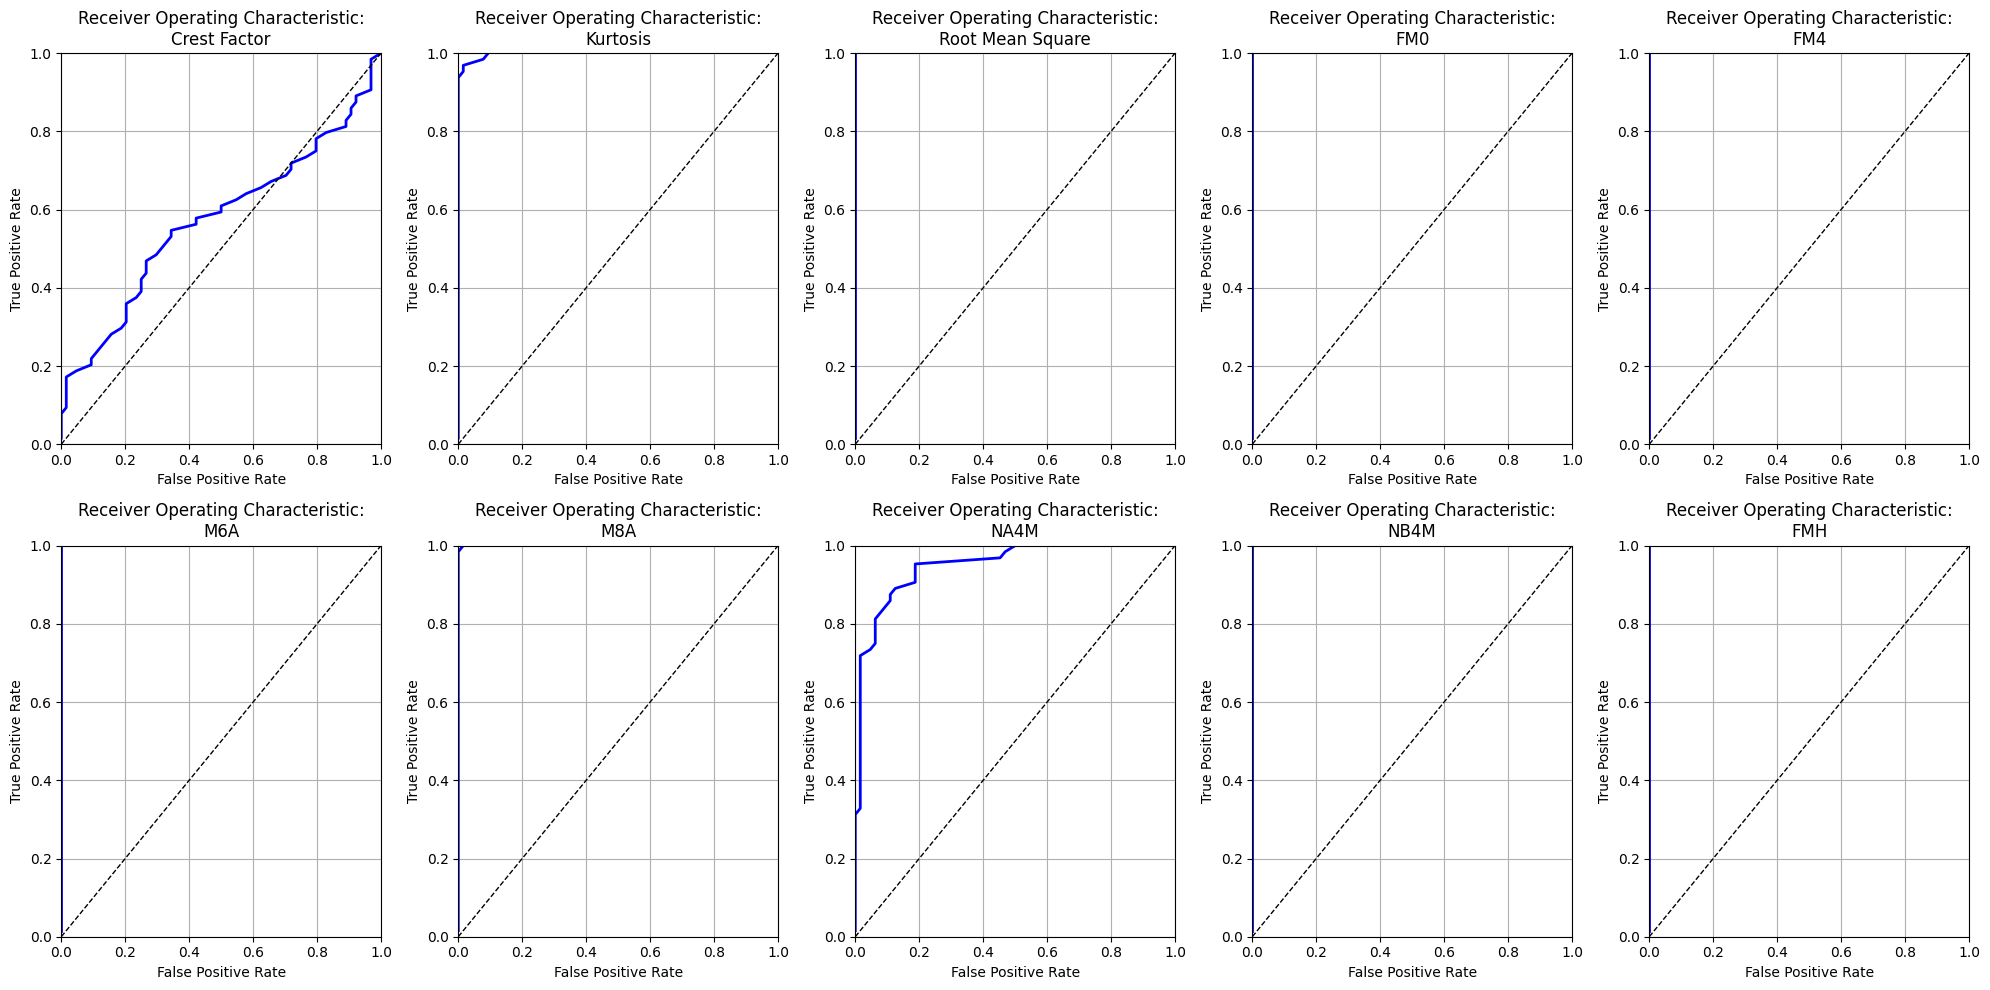

ROC curve analysis complete
Phase 17: CBM Gear Box Analysis - COMPLETE


In [16]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

thresholdTypes = ['below', 'below', 'above', 'above', 'below', 'below',
                  'below', 'above', 'below', 'above']

for i in range(len(featNames)):
    ax = axes[i]
    
    # Create damage state labels (0 for baseline, 1 for damage)
    damage_labels = np.concatenate([np.zeros(len(iBaseline)), np.ones(len(iDamage))])
    
    TPR, FPR = roc_shm(features[:, i], damage_labels, None, thresholdTypes[i])
    
    # Plot ROC curve using basic matplotlib since plot_roc_shm might have different signature
    ax.plot(FPR, TPR, 'b-', linewidth=2, label='ROC Curve')
    ax.plot([0, 1], [0, 1], '--k', linewidth=1, label='Random')
    ax.grid(True)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver Operating Characteristic:\n{featNames[i]}')

plt.tight_layout()
plt.show()

print("ROC curve analysis complete")
print("Phase 17: CBM Gear Box Analysis - COMPLETE")